# attempt to detect ticked/unticked and circled/not-circled images using openCV

In [ ]:
import importlib
import main
import os

importlib.reload(main)
from main import *

folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
]


def list_files_in_folder(folder_path, ext=None):
    """
    Returns a list of file names in the given folder, optionally filtering by extension.

    Parameters:
        folder_path (str): The path to the folder.
        ext (str, optional): The file extension to filter by (e.g., 'png'). Defaults to None.

    Returns:
        list: A list of file names matching the extension.
    """
    try:
        # List all files in the directory
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

        if ext is not None:
            # Normalize the extension to lowercase
            ext = ext.lower()
            # Filter files by extension (case-insensitive)
            files = [f for f in files if os.path.splitext(f)[1].lower() == f".{ext}"]

        return files

    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")
        return []


threshold = 60  # Set your desired threshold

folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
]
for folder in folder_list:
    image_paths = list_files_in_folder(folder, ext="PNG")

    print(folder)
    for file_name in image_paths:
        full_file_path = os.path.join(folder, file_name)

        filename = full_file_path.split("/")[-1]
        name = filename.split(".")[0]
        unique_strings = [
            "no1_93",
            "no1_86",
            "yes1_2",
            "no1_96",
            "no1_97",
            "yes1_79",
            "no1_27",
            "no1_2",
            "no4",
            "no1_71",
            "yes1_60",
            "no1_22",
        ]

        # if name  in unique_strings:
        if name in unique_strings or 1:
            # break

            result_payload = process_image(full_file_path, threshold=threshold, show_plots=False)
            LOGGER.info(result_payload)

            # Save the resulting images with green or red text
            output_directory = "results"
            file_name_prefix = os.path.splitext(os.path.basename(filename))[0]  # Use the original file name as prefix
            image = cv2.imread(full_file_path)
            annotated_image_path = annotate_image_openCV(
                image=image,
                result_payload=result_payload,
                output_path=output_directory,
                file_name_prefix=file_name_prefix,
            )

In [3]:
# epsilon_values = [0.01, 0.02, 0.03, 0.05]

# for epsilon_multiplier in epsilon_values:
#     print(f"\nTesting with epsilon_multiplier = {epsilon_multiplier}")
#     tick_detected, detection_info = detect_checkbox_with_tick(
#         gray,
#         area_threshold=100,
#         epsilon_multiplier=epsilon_multiplier,
#         debug=True,
#         show_plots=True
#     )

In [4]:
# param_ranges = {
#     'clahe_clip_limits': [1.0, 1.5, 2.0],
#     'tile_grid_sizes': [(4, 4), (8, 8)],
#     'block_sizes': [15, 21, 31],  # Must be odd numbers
#     'C_values': [2, 3, 5],
#     'area_thresholds': [50, 100, 200]
# }
# full_file_path = "dataset/images_test/no1_93.PNG"
# explore_detection_parameters(full_file_path, param_ranges)

# attempt to use a CNN model and identity detect ticked/unticked and circled/not-circled images

## training the model

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report,confusion_matrix
import logging
import random

# Set the random seeds for reproducibility
os.environ["PYTHONHASHSEED"] = "0"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Initialize logger
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)


# Load and preprocess images
def load_images_from_folder(folder):
    current_dir = os.getcwd()
    folder_path = os.path.join(current_dir, folder)
    LOGGER.info(f"Folder path is {folder_path}")
    images = []
    labels = []

    if not os.path.isdir(folder_path):
        raise ValueError(f"Folder {folder_path} does not exist.")

    for label in os.listdir(folder_path):
        LOGGER.info(f"Processing label: {label}")
        if label == "images_test":
            continue
        label_folder = os.path.join(folder_path, label)
        LOGGER.info(f"Label '{label}' folder is {label_folder}")
        if not os.path.isdir(label_folder):
            continue
        # Walk through the label folder and its subfolders
        for root, dirs, files in os.walk(label_folder):
            for file in files:
                img_path = os.path.join(root, file)
                # LOGGER.info(f"Processing image {img_path}")
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                if img is not None:
                    img = cv2.resize(img, (80, 140))  # Resize to 80x140 (width x height) for the model
                    images.append(img)
                    labels.append(label)
                else:
                    LOGGER.warning(f"Failed to load image {img_path}")
        # Removed the 'break' statement to allow processing all labels

    return np.array(images), np.array(labels)


# Load data
LOGGER.info("Loading images from dataset")
image_data, labels = load_images_from_folder("dataset/")
image_data = image_data.reshape(-1, 140, 80, 1)  # Add channel dimension for grayscale
image_data = image_data / 255.0  # Normalize the pixel values

# Convert labels to integers (e.g., ticked=0, unticked=1, circled_yes=2, circled_no=3)
LOGGER.info("Labeling images")
label_mapping = {"ticked": 0, "unticked": 1, "circled_yes": 2, "circled_no": 3}
labels = np.array([label_mapping[label] for label in labels])

# Count the number of images per label
unique_labels, counts = np.unique(labels, return_counts=True)
label_names = {v: k for k, v in label_mapping.items()}  # Reverse mapping
print("\nNumber of images per label in the entire dataset:")
for label_int, count in zip(unique_labels, counts):
    label_name = label_names[label_int]
    print(f"{label_name} ({label_int}): {count} images")

# Split data into training, validation, and testing
LOGGER.info("Splitting data into training, validation, and testing")
X_train_full, X_test, y_train_full, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)  # 10% of training data for validation


# Function to count labels
def count_labels(y, dataset_name):
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"\nNumber of images per label in the {dataset_name} set:")
    for label_int, count in zip(unique_labels, counts):
        label_name = label_names[label_int]
        print(f"{label_name} ({label_int}): {count} images")


# Count labels in each dataset
count_labels(y_train, "training")
count_labels(y_val, "validation")
count_labels(y_test, "testing")

# Compute class weights
class_weights_array = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_array))


# Create the CNN model
LOGGER.info("Creating CNN model based on the original architecture")
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(140, 80, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Third convolutional block
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))  # Added pooling layer
model.add(layers.Dropout(0.25))

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))  # Increased neurons
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation="softmax"))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model without data augmentation
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    class_weight=class_weights,
)


print("")
print("")
print("")
print("")
print("")


# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Model Loss")

plt.tight_layout()
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
LOGGER.info(f"Test accuracy: {test_acc}")


# Evaluate the model
LOGGER.info("\nEvaluating the model")
LOGGER.info("Classification Report")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
LOGGER.info(classification_report(y_test, y_pred, target_names=label_mapping.keys()))



conf_mat = confusion_matrix(y_test, y_pred)
LOGGER.info("Confusion Matrix:")
LOGGER.info(conf_mat)

KeyboardInterrupt: 

5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

2024-11-24 05:59:29.108050: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


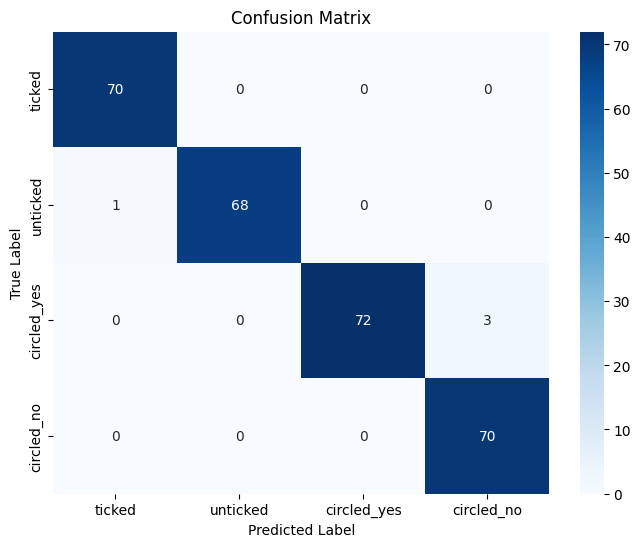

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Now compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create ordered list of class names based on label_mapping
label_mapping = {"ticked": 0, "unticked": 1, "circled_yes": 2, "circled_no": 3}
# Create a list of class names ordered by their label indices
class_names = [""] * len(label_mapping)
for class_name, index in label_mapping.items():
    class_names[index] = class_name

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
## Attempt to improve model by reducing parameters 

INFO:__main__:Loading images from dataset
INFO:__main__:Folder path is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/
INFO:__main__:Processing label: .DS_Store
INFO:__main__:Label '.DS_Store' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/.DS_Store
INFO:__main__:Processing label: ticked
INFO:__main__:Label 'ticked' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/ticked
INFO:__main__:Processing label: circled_yes
INFO:__main__:Label 'circled_yes' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/circled_yes
INFO:__main__:Processing label: images_test
INFO:__main__:Processing label: circled_no
INFO:__main__:Label 'circled_no' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/circled_no
INFO:__main__:Processing label: unticked
INFO:__main__:Label 'unticked' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/unticked
INFO:__main__:Labeling images
INFO:__main__:Splitting data into training, validation, and testing
I


Number of images per label in the entire dataset:
ticked (0): 366 images
unticked (1): 353 images
circled_yes (2): 359 images
circled_no (3): 341 images

Number of images per label in the training set:
ticked (0): 263 images
unticked (1): 254 images
circled_yes (2): 258 images
circled_no (3): 246 images

Number of images per label in the validation set:
ticked (0): 30 images
unticked (1): 28 images
circled_yes (2): 29 images
circled_no (3): 27 images

Number of images per label in the testing set:
ticked (0): 73 images
unticked (1): 71 images
circled_yes (2): 72 images
circled_no (3): 68 images


INFO:__main__:Compiling the model


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 140, 80, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 140, 80, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 140, 80, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 70, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 70, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 70, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 70, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 70, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 35, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 35, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 35, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 35, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 35, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 17, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 17, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,084 (398.77 KB)

 Trainable params: 101,636 (397.02 KB)

 Non-trainable params: 448 (1.75 KB)

INFO:__main__:Training the model


Epoch 1/100


/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3388 - loss: 1.3592 - val_accuracy: 0.2368 - val_loss: 1.3911 - learning_rate: 1.0000e-04
Epoch 2/100


2024-11-23 07:12:31.482261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/brunoviola/.pyenv/versions/3.10.6/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2368 - val_loss: 1.3911 - learning_rate: 1.0000e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - accuracy: 0.5920 - loss: 1.0351 - val_accuracy: 0.2368 - val_loss: 1.4146 - learning_rate: 1.0000e-04
Epoch 4/100


2024-11-23 07:12:51.697753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2368 - val_loss: 1.4146 - learning_rate: 1.0000e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.6907 - loss: 0.8979 - val_accuracy: 0.2368 - val_loss: 1.4532 - learning_rate: 5.0000e-05
Epoch 6/100


2024-11-23 07:13:08.541008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2368 - val_loss: 1.4532 - learning_rate: 5.0000e-05
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 533ms/step - accuracy: 0.6611 - loss: 0.8703 - val_accuracy: 0.2368 - val_loss: 1.5090 - learning_rate: 5.0000e-05
Epoch 8/100


2024-11-23 07:13:26.092691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2368 - val_loss: 1.5090 - learning_rate: 2.5000e-05
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 488ms/step - accuracy: 0.7108 - loss: 0.8094 - val_accuracy: 0.2368 - val_loss: 1.5698 - learning_rate: 2.5000e-05
Epoch 10/100


2024-11-23 07:13:42.252839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2368 - val_loss: 1.5698 - learning_rate: 2.5000e-05
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 505ms/step - accuracy: 0.7348 - loss: 0.7797 - val_accuracy: 0.2368 - val_loss: 1.6330 - learning_rate: 1.2500e-05


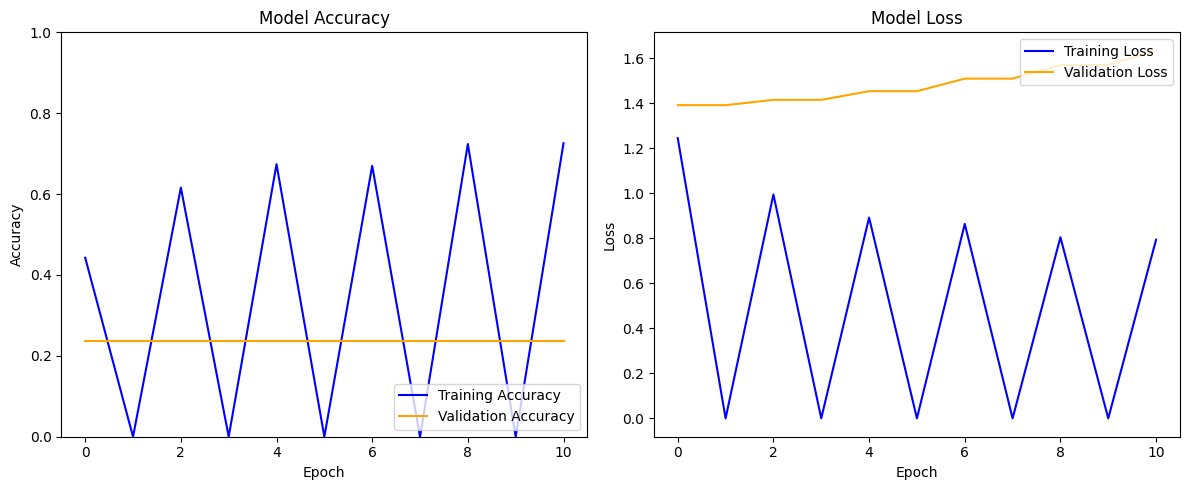

9/9 - 1s - 109ms/step - accuracy: 0.2394 - loss: 1.3904


INFO:__main__:Test accuracy: 0.23943662643432617
INFO:__main__:
Evaluating the model
INFO:__main__:Classification Report


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
              precision    recall  f1-score   support

      ticked       0.00      0.00      0.00        73
    unticked       0.00      0.00      0.00        71
 circled_yes       0.00      0.00      0.00        72
  circled_no       0.24      1.00      0.39        68

    accuracy                           0.24       284
   macro avg       0.06      0.25      0.10       284
weighted avg       0.06      0.24      0.09       284



/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [96]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import logging
import random

# Set the random seeds for reproducibility
os.environ["PYTHONHASHSEED"] = "0"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Initialize logger
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Load and preprocess images
def load_images_from_folder(folder):
    current_dir = os.getcwd()
    folder_path = os.path.join(current_dir, folder)
    LOGGER.info(f"Folder path is {folder_path}")
    images = []
    labels = []

    if not os.path.isdir(folder_path):
        raise ValueError(f"Folder {folder_path} does not exist.")

    for label in os.listdir(folder_path):
        LOGGER.info(f"Processing label: {label}")
        if label == "images_test":
            continue
        label_folder = os.path.join(folder_path, label)
        LOGGER.info(f"Label '{label}' folder is {label_folder}")
        if not os.path.isdir(label_folder):
            continue
        # Walk through the label folder and its subfolders
        for root, dirs, files in os.walk(label_folder):
            for file in files:
                img_path = os.path.join(root, file)
                # LOGGER.info(f"Processing image {img_path}")
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                if img is not None:
                    img = cv2.resize(img, (80, 140))  # Resize to 80x140 (width x height) for the model
                    images.append(img)
                    labels.append(label)
                else:
                    LOGGER.warning(f"Failed to load image {img_path}")
        # Removed the 'break' statement to allow processing all labels

    return np.array(images), np.array(labels)

# Load data
LOGGER.info("Loading images from dataset")
image_data, labels = load_images_from_folder("dataset/")
image_data = image_data.reshape(-1, 140, 80, 1)  # Add channel dimension for grayscale
image_data = image_data / 255.0  # Normalize the pixel values

# Convert labels to integers (e.g., ticked=0, unticked=1, circled_yes=2, circled_no=3)
LOGGER.info("Labeling images")
label_mapping = {"ticked": 0, "unticked": 1, "circled_yes": 2, "circled_no": 3}
labels = np.array([label_mapping[label] for label in labels])

# Count the number of images per label
unique_labels, counts = np.unique(labels, return_counts=True)
label_names = {v: k for k, v in label_mapping.items()}  # Reverse mapping
print("\nNumber of images per label in the entire dataset:")
for label_int, count in zip(unique_labels, counts):
    label_name = label_names[label_int]
    print(f"{label_name} ({label_int}): {count} images")

# Split data into training, validation, and testing
LOGGER.info("Splitting data into training, validation, and testing")
X_train_full, X_test, y_train_full, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)  # 10% of training data for validation

# Function to count labels
def count_labels(y, dataset_name):
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"\nNumber of images per label in the {dataset_name} set:")
    for label_int, count in zip(unique_labels, counts):
        label_name = label_names[label_int]
        print(f"{label_name} ({label_int}): {count} images")

# Count labels in each dataset
count_labels(y_train, "training")
count_labels(y_val, "validation")
count_labels(y_test, "testing")

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = dict(enumerate(class_weights_array))

# Create the CNN model with adjusted parameters
LOGGER.info("Creating CNN model with adjustments")
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(140, 80, 1)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))  # Reduced dropout

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Third convolutional block
model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Global Average Pooling and dense layers
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))  # Reduced dropout
model.add(layers.Dense(4, activation='softmax'))

# Optimizer and learning rate scheduler
optimizer = Adam(learning_rate=0.0001)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

# Compile the model
LOGGER.info("Compiling the model")
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Data augmentation with reduced transformations
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
)

# Fit the generator to the training data
datagen.fit(X_train)

# Early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Adjust steps_per_epoch
steps_per_epoch = int(np.ceil(len(X_train) / 32))

# Train the model
LOGGER.info("Training the model")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback],
    class_weight=class_weights,
    steps_per_epoch=steps_per_epoch,
)
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Model Loss")

plt.tight_layout()
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
LOGGER.info(f"Test accuracy: {test_acc}")

# Evaluate the model
LOGGER.info("\nEvaluating the model")
LOGGER.info("Classification Report")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))


saving the model

In [88]:
model.save("image_model.keras")  # 98%

### function that wrangles images

In [8]:
import os
import random  # New import for randomness
from PIL import Image
import matplotlib.pyplot as plt


def process_images(
    folder_path, prefix, new_resolution=None, new_size=None, plot_images=False, seed=None, max_counter=None
):
    # Collect image filenames
    image_filenames = [
        filename
        for filename in os.listdir(folder_path)
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".tiff", ".bmp", ".gif"))
    ]

    # Introduce randomness with a seed
    if seed is not None:
        random.seed(seed)
        random.shuffle(image_filenames)

    counter = 1
    output_folder = os.path.join(folder_path, "processed_images")
    os.makedirs(output_folder, exist_ok=True)
    print(f"current counter is {counter}")
    for filename in image_filenames:
        # Stop processing if max_counter is reached
        if max_counter is not None and counter > max_counter:
            print(f"reached max counter {max_counter}")
            break

        original_file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(original_file_path) as img:
                # Get image info
                dpi = img.info.get("dpi", (72, 72))  # Default DPI is (72, 72) if not specified
                width, height = img.size
                file_size = os.path.getsize(original_file_path)
                print(f"Counter: {counter}")
                print(f"Name: {filename}")
                print(f"Resolution (DPI): {dpi}")
                print(f"Dimensions: {width}x{height}")
                print(f"File size: {file_size} bytes\n")

                # Generate new filename
                file_extension = os.path.splitext(filename)[1]
                new_filename = f"{prefix}{counter}{file_extension}"
                new_file_path = os.path.join(output_folder, new_filename)

                # Avoid filename collisions
                while os.path.exists(new_file_path):
                    counter += 1
                    new_filename = f"{prefix}{counter}{file_extension}"
                    new_file_path = os.path.join(output_folder, new_filename)

                # Optionally resize the image
                img_for_saving = img
                if new_size:
                    img_for_saving = img.resize(new_size, Image.LANCZOS)

                # Save image with new DPI and/or size
                save_kwargs = {}
                if new_resolution:
                    save_kwargs["dpi"] = new_resolution
                img_for_saving.save(new_file_path, **save_kwargs)

                # If plotting is enabled, display the original and new images side by side
                if plot_images:
                    with Image.open(new_file_path) as new_img:
                        original_img_plot = img.convert("RGB")
                        new_img_plot = new_img.convert("RGB")

                        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                        axes[0].imshow(original_img_plot)
                        axes[0].set_title("Original Image")
                        axes[0].axis("off")

                        axes[1].imshow(new_img_plot)
                        axes[1].set_title("New Image")
                        axes[1].axis("off")

                        plt.show()

                counter += 1

        except Exception as e:
            print(f"Error processing {filename}: {e}")


# Usage
# data = ("dataset/circled_yes", "circled_")
# data = ('dataset/circled_no',"not_circled_")
data = ("dataset/ticked", "ticked_")
# data = ('dataset/unticked',"not_ticked_")
folder_path = data[0]
prefix = data[1]


# new_resolution = (300, 300)           # Desired DPI, or None to keep original

# new_size = (120, 80)
# new_size = (100, 60)
# new_size = (60, 100)
# new_size = (80, 80)
# new_size = (70, 70)
new_size = (90, 90)
# new_size = (60, 60)
plot_images = False  # Set to True to plot images side by side
seed = 42  # Set to an integer value for reproducibility
max_counter = 10  # Process only up to this number of images

# process_images(folder_path, prefix, new_resolution, new_size, plot_images, seed, max_counter)

process_images(folder_path, prefix, new_size=new_size, plot_images=plot_images, seed=seed, max_counter=max_counter)

current counter is 1
Counter: 1
Name: yes1 61.PNG
Resolution (DPI): (72, 72)
Dimensions: 146x77
File size: 1371 bytes

Counter: 2
Name: no2 19.PNG
Resolution (DPI): (72, 72)
Dimensions: 133x75
File size: 2171 bytes

Counter: 3
Name: yes1 26.PNG
Resolution (DPI): (72, 72)
Dimensions: 160x86
File size: 1067 bytes

Counter: 4
Name: yes1_9.PNG
Resolution (DPI): (72, 72)
Dimensions: 146x79
File size: 8530 bytes

Counter: 5
Name: yes1_51.PNG
Resolution (DPI): (72, 72)
Dimensions: 155x77
File size: 2234 bytes

Counter: 6
Name: no1 17.PNG
Resolution (DPI): (72, 72)
Dimensions: 109x64
File size: 9365 bytes

Counter: 7
Name: yes1_77.PNG
Resolution (DPI): (72, 72)
Dimensions: 155x79
File size: 2242 bytes

Counter: 8
Name: yes1 29.PNG
Resolution (DPI): (72, 72)
Dimensions: 116x63
File size: 9738 bytes

Counter: 9
Name: no2 23.PNG
Resolution (DPI): (72, 72)
Dimensions: 132x77
File size: 2445 bytes

Counter: 10
Name: yes1 40.PNG
Resolution (DPI): (72, 72)
Dimensions: 142x78
File size: 1395 bytes

re

Understanding the Classification Report

The classification report generated by sklearn.metrics.classification_report provides a detailed summary of the predictive performance of a classification model. It includes key metrics for each class in your dataset, helping you understand how well your model is performing, especially in cases of imbalanced datasets.
Metrics Included in the Classification Report

The report includes the following metrics for each class:

    Precision
    Recall
    F1-Score
    Support

These metrics provide insights into different aspects of your model's performance.
1. Precision

Definition:

    Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

Formula:
Precision=True Positives (TP)True Positives (TP)+False Positives (FP)
Precision=True Positives (TP)+False Positives (FP)True Positives (TP)​

Interpretation:

    Precision answers the question: "Of all instances that the model predicted as positive (e.g., a specific class), how many are actually positive?"
    A high precision indicates a low rate of false positives.

2. Recall (Sensitivity or True Positive Rate)

Definition:

    Recall is the ratio of correctly predicted positive observations to all actual positive observations.

Formula:
Recall=True Positives (TP)True Positives (TP)+False Negatives (FN)
Recall=True Positives (TP)+False Negatives (FN)True Positives (TP)​

Interpretation:

    Recall answers the question: "Of all actual positive instances, how many did the model correctly identify?"
    A high recall indicates a low rate of false negatives.

3. F1-Score

Definition:

    The F1-score is the harmonic mean of precision and recall. It combines both metrics into a single value.

Formula:
F1-Score=2×Precision×RecallPrecision+Recall
F1-Score=2×Precision+RecallPrecision×Recall​

Interpretation:

    F1-score balances the trade-off between precision and recall.
    It's useful when you need to seek a balance between precision and recall, especially with uneven class distribution.

4. Support

Definition:

    Support refers to the number of actual occurrences of each class in the dataset.

Interpretation:

    It shows how many samples of each class are present in the test dataset.
    Important for understanding the weight of each class in the overall performance metrics.

## saving the model

In [82]:
# model.save('ticked_box_model.h5')
# model.save('ticked_box_model_new.keras')
# model.save('ticked_box_model_more_images.keras')
model.save("ticked_box_model_image_augumentation.keras")  # 97%

## load the model

In [89]:
# Load the trained model globally so it's available in subsequent requests
# model = tf.keras.models.load_model('ticked_box_model_new.keras')
# model = tf.keras.models.load_model('ticked_box_model_more_images.keras')
model = tf.keras.models.load_model('image_model.keras')

## predict

In [16]:
import os
import cv2
import logging
from io import BytesIO
from collections import defaultdict
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from main import *

# Initialize logging
LOGGER = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# Define paths and settings
folder_list = ["dataset/images_test"]
widths = []
heights = []
aspect_ratios = []

model = load_model("image_classifier.keras")
threshold = 0.8

# Function to list files in a folder
def list_files_in_folder(folder, ext="PNG"):
    return [
        file for file in os.listdir(folder)
        if file.endswith(ext) and os.path.isfile(os.path.join(folder, file))
    ]

# Initialize metrics storage
results = defaultdict(lambda: {"true_positive": 0, "false_positive": 0, "true_negative": 0, "false_negative": 0})
all_predictions = []
all_true_labels = []

# Process each folder
for root_folder in folder_list:
    for label_folder in os.listdir(root_folder):
        label_path = os.path.join(root_folder, label_folder)
        if not os.path.isdir(label_path):
            continue
        
        # Real label is the folder name
        real_label = label_folder
        
        LOGGER.info(f"Processing folder: {label_path} with label: {real_label}")
        image_paths = list_files_in_folder(label_path, ext="PNG")
        
        for file_name in image_paths:
            file_path = os.path.join(label_path, file_name)
            LOGGER.info("\n\n")
            LOGGER.info(f"Processing image: {file_path}")
            
            try:
                # Load and process the image
                image = cv2.imread(file_path)
                if image is None:
                    LOGGER.error(f"Failed to read image: {file_path}")
                    continue
                
                h, w = image.shape[:2]
                widths.append(w)
                heights.append(h)
                aspect_ratios.append(w / h)
                
                # Convert image to bytes
                with open(file_path, "rb") as image_file:
                    image_bytes = BytesIO(image_file.read())
                
                # Predict using the model
                result_payload = process_image_with_model(image_bytes, threshold, model)
                LOGGER.info(f"Raw predictions: {result_payload}")

                # Determine the label with the highest confidence
                predicted_label = max(result_payload, key=result_payload.get)
                confidence = result_payload[predicted_label]

                LOGGER.info(f"Processed response: {result_payload}")
                
                # Store predictions and labels for the report
                all_predictions.append(predicted_label)
                all_true_labels.append(real_label)
                
                # Calculate metrics
                for label in result_payload.keys():
                    if label == real_label:
                        if label == predicted_label:
                            results[label]["true_positive"] += 1
                        else:
                            results[label]["false_negative"] += 1
                    else:
                        if label == predicted_label:
                            results[label]["false_positive"] += 1
                        else:
                            results[label]["true_negative"] += 1
                
                # Log the prediction result
                if predicted_label == real_label:
                    LOGGER.info(f"Correct Prediction: {predicted_label} (Confidence: {confidence:.2f})")
                else:
                    LOGGER.warning(f"Incorrect Prediction: {predicted_label} (Confidence: {confidence:.2f}), Real Label: {real_label}")
                
                # Build consent dictionary
                consent = build_consent(result_payload, threshold)
                
                # Annotate the image
                output_directory = "results_model"
                file_name_prefix = os.path.splitext(os.path.basename(file_path))[0]
                annotated_image_path = annotate_image(
                    image=image, consent=consent, output_path=output_directory, file_name_prefix=file_name_prefix
                )
                LOGGER.info(f"Annotated image saved at: {annotated_image_path}")
            
            except Exception as e:
                LOGGER.exception(f"An unexpected error occurred while processing image {file_path}: {e}")


# Generate report after all predictions
LOGGER.info("\n=== Classification Report ===\n%s", classification_report(all_true_labels, all_predictions, target_names=list(results.keys())))



LOGGER.info("\n=== Confusion Matrix ===\n%s", confusion_matrix(all_true_labels, all_predictions, labels=list(results.keys())))


# Output detailed metrics for each label
LOGGER.info("\n=== Detailed Metrics ===")
for label, metrics in results.items():
    LOGGER.info(f"Label: {label}")
    LOGGER.info(f"  True Positives: {metrics['true_positive']}")
    LOGGER.info(f"  False Positives: {metrics['false_positive']}")
    LOGGER.info(f"  True Negatives: {metrics['true_negative']}")
    LOGGER.info(f"  False Negatives: {metrics['false_negative']}")


INFO:__main__:Processing folder: dataset/images_test/unticked with label: unticked
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/unticked/no1_70.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


2024-11-24 06:41:31.290362: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
INFO:__main__:Raw predictions: {'ticked': 4.1244096792070195e-05, 'unticked': 0.9999579191207886, 'circled_yes': 1.0773260328278411e-07, 'circled_no': 6.997707941991393e-07}
INFO:__main__:Processed response: {'ticked': 4.1244096792070195e-05, 'unticked': 0.9999579191207886, 'circled_yes': 1.07

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 5.323985533323139e-05, 'unticked': 0.9999454021453857, 'circled_yes': 3.55819651076672e-07, 'circled_no': 8.99137035048625e-07}
INFO:__main__:Processed response: {'ticked': 5.323985533323139e-05, 'unticked': 0.9999454021453857, 'circled_yes': 3.55819651076672e-07, 'circled_no': 8.99137035048625e-07}
INFO:__main__:Correct Prediction: unticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_71_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/unticked/no1_69.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


INFO:__main__:Raw predictions: {'ticked': 3.858556283375947e-06, 'unticked': 0.9999961853027344, 'circled_yes': 1.5567911404446022e-08, 'circled_no': 8.636615866919328e-09}
INFO:__main__:Processed response: {'ticked': 3.858556283375947e-06, 'unticked': 0.9999961853027344, 'circled_yes': 1.5567911404446022e-08, 'circled_no': 8.636615866919328e-09}
INFO:__main__:Correct Prediction: unticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_69_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/unticked/no1_65.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:__main__:Raw predictions: {'ticked': 3.2607383673166623e-06, 'unticked': 0.9999966621398926, 'circled_yes': 1.8644090715724815e-08, 'circled_no': 9.990547056304422e-09}
INFO:__main__:Processed response: {'ticked': 3.2607383673166623e-06, 'unticked': 0.9999966621398926, 'circled_yes': 1.8644090715724815e-08, 'circled_no': 9.990547056304422e-09}
INFO:__main__:Correct Prediction: unticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_65_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/unticked/no1_18.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 3.2607383673166623e-06, 'unticked': 0.9999966621398926, 'circled_yes': 1.8644090715724815e-08, 'circled_no': 9.990547056304422e-09}
INFO:__main__:Processed response: {'ticked': 3.2607383673166623e-06, 'unticked': 0.9999966621398926, 'circled_yes': 1.8644090715724815e-08, 'circled_no': 9.990547056304422e-09}
INFO:__main__:Correct Prediction: unticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_18_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/unticked/no1_25.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


INFO:__main__:Raw predictions: {'ticked': 1.3375743037613574e-06, 'unticked': 0.9999986886978149, 'circled_yes': 3.969616635401962e-09, 'circled_no': 9.721849991706222e-09}
INFO:__main__:Processed response: {'ticked': 1.3375743037613574e-06, 'unticked': 0.9999986886978149, 'circled_yes': 3.969616635401962e-09, 'circled_no': 9.721849991706222e-09}
INFO:__main__:Correct Prediction: unticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_25_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/unticked/no1_22.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:__main__:Raw predictions: {'ticked': 8.188362130567839e-07, 'unticked': 0.9999991655349731, 'circled_yes': 1.5889297655391488e-09, 'circled_no': 4.974292266979319e-08}
INFO:__main__:Processed response: {'ticked': 8.188362130567839e-07, 'unticked': 0.9999991655349731, 'circled_yes': 1.5889297655391488e-09, 'circled_no': 4.974292266979319e-08}
INFO:__main__:Correct Prediction: unticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_22_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/unticked/no1_17.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:__main__:Raw predictions: {'ticked': 3.2670595828676596e-06, 'unticked': 0.9999964237213135, 'circled_yes': 1.4453934049640793e-08, 'circled_no': 2.2947199340705993e-07}
INFO:__main__:Processed response: {'ticked': 3.2670595828676596e-06, 'unticked': 0.9999964237213135, 'circled_yes': 1.4453934049640793e-08, 'circled_no': 2.2947199340705993e-07}
INFO:__main__:Correct Prediction: unticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_17_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/unticked/no1_27.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 0.00013276866229716688, 'unticked': 0.9998669624328613, 'circled_yes': 1.3486877037394152e-07, 'circled_no': 7.934593782010779e-08}
INFO:__main__:Processed response: {'ticked': 0.00013276866229716688, 'unticked': 0.9998669624328613, 'circled_yes': 1.3486877037394152e-07, 'circled_no': 7.934593782010779e-08}
INFO:__main__:Correct Prediction: unticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_27_annotated.png
INFO:__main__:Processing folder: dataset/images_test/circled_no with label: circled_no
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:__main__:Raw predictions: {'ticked': 1.0130233363270236e-07, 'unticked': 2.5801811716519296e-05, 'circled_yes': 1.1732527127605863e-06, 'circled_no': 0.999972939491272}
INFO:__main__:Processed response: {'ticked': 1.0130233363270236e-07, 'unticked': 2.5801811716519296e-05, 'circled_yes': 1.1732527127605863e-06, 'circled_no': 0.999972939491272}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no1_86.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 1.0013473605852141e-08, 'unticked': 3.151588680339046e-05, 'circled_yes': 9.907832918543136e-07, 'circled_no': 0.9999675750732422}
INFO:__main__:Processed response: {'ticked': 1.0013473605852141e-08, 'unticked': 3.151588680339046e-05, 'circled_yes': 9.907832918543136e-07, 'circled_no': 0.9999675750732422}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_86_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no1_91.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


INFO:__main__:Raw predictions: {'ticked': 6.5791110337443115e-09, 'unticked': 5.44346657989081e-05, 'circled_yes': 7.471170704320684e-08, 'circled_no': 0.9999454021453857}
INFO:__main__:Processed response: {'ticked': 6.5791110337443115e-09, 'unticked': 5.44346657989081e-05, 'circled_yes': 7.471170704320684e-08, 'circled_no': 0.9999454021453857}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_91_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no5.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:__main__:Raw predictions: {'ticked': 4.127626684891084e-09, 'unticked': 2.2981072106631473e-05, 'circled_yes': 1.2162938389792544e-07, 'circled_no': 0.9999768733978271}
INFO:__main__:Processed response: {'ticked': 4.127626684891084e-09, 'unticked': 2.2981072106631473e-05, 'circled_yes': 1.2162938389792544e-07, 'circled_no': 0.9999768733978271}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no5_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no4.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


INFO:__main__:Raw predictions: {'ticked': 9.711221826691485e-10, 'unticked': 9.190342098008841e-06, 'circled_yes': 3.049608565675044e-08, 'circled_no': 0.9999908208847046}
INFO:__main__:Processed response: {'ticked': 9.711221826691485e-10, 'unticked': 9.190342098008841e-06, 'circled_yes': 3.049608565675044e-08, 'circled_no': 0.9999908208847046}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no4_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:__main__:Raw predictions: {'ticked': 1.1266397814679863e-09, 'unticked': 1.4724006177857518e-05, 'circled_yes': 3.102292467360712e-08, 'circled_no': 0.9999852180480957}
INFO:__main__:Processed response: {'ticked': 1.1266397814679863e-09, 'unticked': 1.4724006177857518e-05, 'circled_yes': 3.102292467360712e-08, 'circled_no': 0.9999852180480957}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no2_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no1_64.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


INFO:__main__:Raw predictions: {'ticked': 1.0906163794288659e-07, 'unticked': 3.775950244744308e-05, 'circled_yes': 1.7704301171761472e-06, 'circled_no': 0.9999603033065796}
INFO:__main__:Processed response: {'ticked': 1.0906163794288659e-07, 'unticked': 3.775950244744308e-05, 'circled_yes': 1.7704301171761472e-06, 'circled_no': 0.9999603033065796}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_64_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no6.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


INFO:__main__:Raw predictions: {'ticked': 3.523134006755413e-10, 'unticked': 5.386008524510544e-06, 'circled_yes': 1.818120409780022e-08, 'circled_no': 0.9999946355819702}
INFO:__main__:Processed response: {'ticked': 3.523134006755413e-10, 'unticked': 5.386008524510544e-06, 'circled_yes': 1.818120409780022e-08, 'circled_no': 0.9999946355819702}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no6_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no1_75.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:__main__:Raw predictions: {'ticked': 3.222470752461959e-07, 'unticked': 3.156931416015141e-05, 'circled_yes': 2.306672058693948e-06, 'circled_no': 0.9999657869338989}
INFO:__main__:Processed response: {'ticked': 3.222470752461959e-07, 'unticked': 3.156931416015141e-05, 'circled_yes': 2.306672058693948e-06, 'circled_no': 0.9999657869338989}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_75_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no1_82.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


INFO:__main__:Raw predictions: {'ticked': 5.8797304802737926e-08, 'unticked': 6.754963396815583e-05, 'circled_yes': 9.928073723131092e-07, 'circled_no': 0.9999313354492188}
INFO:__main__:Processed response: {'ticked': 5.8797304802737926e-08, 'unticked': 6.754963396815583e-05, 'circled_yes': 9.928073723131092e-07, 'circled_no': 0.9999313354492188}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_82_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no3.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


INFO:__main__:Raw predictions: {'ticked': 9.82767911494875e-09, 'unticked': 2.8892167392768897e-05, 'circled_yes': 2.045116502813471e-07, 'circled_no': 0.9999709129333496}
INFO:__main__:Processed response: {'ticked': 9.82767911494875e-09, 'unticked': 2.8892167392768897e-05, 'circled_yes': 2.045116502813471e-07, 'circled_no': 0.9999709129333496}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no3_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_no/no1_66.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


INFO:__main__:Raw predictions: {'ticked': 3.222470752461959e-07, 'unticked': 3.156931416015141e-05, 'circled_yes': 2.306672058693948e-06, 'circled_no': 0.9999657869338989}
INFO:__main__:Processed response: {'ticked': 3.222470752461959e-07, 'unticked': 3.156931416015141e-05, 'circled_yes': 2.306672058693948e-06, 'circled_no': 0.9999657869338989}
INFO:__main__:Correct Prediction: circled_no (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_66_annotated.png
INFO:__main__:Processing folder: dataset/images_test/ticked with label: ticked
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/no1_93.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9977042078971863, 'unticked': 0.002282501198351383, 'circled_yes': 2.698462594707962e-06, 'circled_no': 1.0549997568887193e-05}
INFO:__main__:Processed response: {'ticked': 0.9977042078971863, 'unticked': 0.002282501198351383, 'circled_yes': 2.698462594707962e-06, 'circled_no': 1.0549997568887193e-05}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_93_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_71.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9919784069061279, 'unticked': 0.007989921607077122, 'circled_yes': 2.8084575660614064e-06, 'circled_no': 2.877155020541977e-05}
INFO:__main__:Processed response: {'ticked': 0.9919784069061279, 'unticked': 0.007989921607077122, 'circled_yes': 2.8084575660614064e-06, 'circled_no': 2.877155020541977e-05}
INFO:__main__:Correct Prediction: ticked (Confidence: 0.99)
INFO:__main__:Annotated image saved at: results_model/yes1_71_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_73.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9998471736907959, 'unticked': 0.0001528183202026412, 'circled_yes': 7.989507944117236e-10, 'circled_no': 2.947004063003078e-08}
INFO:__main__:Processed response: {'ticked': 0.9998471736907959, 'unticked': 0.0001528183202026412, 'circled_yes': 7.989507944117236e-10, 'circled_no': 2.947004063003078e-08}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_73_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_65.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9988299012184143, 'unticked': 0.001168314483948052, 'circled_yes': 1.3361638018238864e-08, 'circled_no': 1.8145955209547537e-06}
INFO:__main__:Processed response: {'ticked': 0.9988299012184143, 'unticked': 0.001168314483948052, 'circled_yes': 1.3361638018238864e-08, 'circled_no': 1.8145955209547537e-06}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_65_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/no1_96.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9970824122428894, 'unticked': 0.0028975135646760464, 'circled_yes': 3.1029928777570603e-06, 'circled_no': 1.695936225587502e-05}
INFO:__main__:Processed response: {'ticked': 0.9970824122428894, 'unticked': 0.0028975135646760464, 'circled_yes': 3.1029928777570603e-06, 'circled_no': 1.695936225587502e-05}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_96_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_70.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9999915361404419, 'unticked': 8.513863576808944e-06, 'circled_yes': 5.250654511873565e-12, 'circled_no': 1.782866854149745e-09}
INFO:__main__:Processed response: {'ticked': 0.9999915361404419, 'unticked': 8.513863576808944e-06, 'circled_yes': 5.250654511873565e-12, 'circled_no': 1.782866854149745e-09}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_70_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/no1_97.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9997437596321106, 'unticked': 0.00023557347594760358, 'circled_yes': 1.3707614016311709e-05, 'circled_no': 6.9584498305630405e-06}
INFO:__main__:Processed response: {'ticked': 0.9997437596321106, 'unticked': 0.00023557347594760358, 'circled_yes': 1.3707614016311709e-05, 'circled_no': 6.9584498305630405e-06}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_97_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_77.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


INFO:__main__:Raw predictions: {'ticked': 0.999847412109375, 'unticked': 0.00015257064660545439, 'circled_yes': 1.848253911029829e-10, 'circled_no': 2.8695716025595175e-08}
INFO:__main__:Processed response: {'ticked': 0.999847412109375, 'unticked': 0.00015257064660545439, 'circled_yes': 1.848253911029829e-10, 'circled_no': 2.8695716025595175e-08}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_77_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_60.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9998383522033691, 'unticked': 0.0001615630608284846, 'circled_yes': 6.907810434775286e-10, 'circled_no': 2.8610092073222404e-08}
INFO:__main__:Processed response: {'ticked': 0.9998383522033691, 'unticked': 0.0001615630608284846, 'circled_yes': 6.907810434775286e-10, 'circled_no': 2.8610092073222404e-08}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_60_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/no1_89.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:__main__:Raw predictions: {'ticked': 0.531279444694519, 'unticked': 0.08090759813785553, 'circled_yes': 0.012399782426655293, 'circled_no': 0.3754131495952606}
INFO:__main__:Processed response: {'ticked': 0.531279444694519, 'unticked': 0.08090759813785553, 'circled_yes': 0.012399782426655293, 'circled_no': 0.3754131495952606}
INFO:__main__:Correct Prediction: ticked (Confidence: 0.53)
INFO:__main__:Annotated image saved at: results_model/no1_89_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_80.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 0.99997878074646, 'unticked': 2.108165790559724e-05, 'circled_yes': 9.940306711087032e-08, 'circled_no': 2.428165224444001e-08}
INFO:__main__:Processed response: {'ticked': 0.99997878074646, 'unticked': 2.108165790559724e-05, 'circled_yes': 9.940306711087032e-08, 'circled_no': 2.428165224444001e-08}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_80_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_59.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9997872710227966, 'unticked': 0.00021247602126095444, 'circled_yes': 3.0289883934386808e-09, 'circled_no': 3.180605006036785e-07}
INFO:__main__:Processed response: {'ticked': 0.9997872710227966, 'unticked': 0.00021247602126095444, 'circled_yes': 3.0289883934386808e-09, 'circled_no': 3.180605006036785e-07}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_59_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_72.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9999641180038452, 'unticked': 3.1902331102173775e-05, 'circled_yes': 3.964578809245722e-06, 'circled_no': 6.27934184649348e-08}
INFO:__main__:Processed response: {'ticked': 0.9999641180038452, 'unticked': 3.1902331102173775e-05, 'circled_yes': 3.964578809245722e-06, 'circled_no': 6.27934184649348e-08}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_72_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_76.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9998062252998352, 'unticked': 0.0001936556218424812, 'circled_yes': 3.036708037806868e-11, 'circled_no': 1.3186550518184958e-07}
INFO:__main__:Processed response: {'ticked': 0.9998062252998352, 'unticked': 0.0001936556218424812, 'circled_yes': 3.036708037806868e-11, 'circled_no': 1.3186550518184958e-07}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_76_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_79.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9992063641548157, 'unticked': 0.0007935134344734251, 'circled_yes': 6.26998897246267e-08, 'circled_no': 8.165622489286761e-08}
INFO:__main__:Processed response: {'ticked': 0.9992063641548157, 'unticked': 0.0007935134344734251, 'circled_yes': 6.26998897246267e-08, 'circled_no': 8.165622489286761e-08}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_79_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/ticked/yes1_69.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


INFO:__main__:Raw predictions: {'ticked': 0.9998471736907959, 'unticked': 0.0001528183202026412, 'circled_yes': 7.989507944117236e-10, 'circled_no': 2.947004063003078e-08}
INFO:__main__:Processed response: {'ticked': 0.9998471736907959, 'unticked': 0.0001528183202026412, 'circled_yes': 7.989507944117236e-10, 'circled_no': 2.947004063003078e-08}
INFO:__main__:Correct Prediction: ticked (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_69_annotated.png
INFO:__main__:Processing folder: dataset/images_test/circled_yes with label: circled_yes
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_yes/no1_8.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


INFO:__main__:Raw predictions: {'ticked': 0.000490305945277214, 'unticked': 0.0005840123048983514, 'circled_yes': 0.9360554814338684, 'circled_no': 0.06287024170160294}
INFO:__main__:Processed response: {'ticked': 0.000490305945277214, 'unticked': 0.0005840123048983514, 'circled_yes': 0.9360554814338684, 'circled_no': 0.06287024170160294}
INFO:__main__:Correct Prediction: circled_yes (Confidence: 0.94)
INFO:__main__:Annotated image saved at: results_model/no1_8_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_yes/yes1_23.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


INFO:__main__:Raw predictions: {'ticked': 0.00020332660642452538, 'unticked': 7.3846954364853445e-06, 'circled_yes': 0.9993785619735718, 'circled_no': 0.0004106037085875869}
INFO:__main__:Processed response: {'ticked': 0.00020332660642452538, 'unticked': 7.3846954364853445e-06, 'circled_yes': 0.9993785619735718, 'circled_no': 0.0004106037085875869}
INFO:__main__:Correct Prediction: circled_yes (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_23_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_yes/yes1_34.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


INFO:__main__:Raw predictions: {'ticked': 1.025348126404424e-07, 'unticked': 3.1467803296436614e-07, 'circled_yes': 0.9999980926513672, 'circled_no': 1.5263233308360213e-06}
INFO:__main__:Processed response: {'ticked': 1.025348126404424e-07, 'unticked': 3.1467803296436614e-07, 'circled_yes': 0.9999980926513672, 'circled_no': 1.5263233308360213e-06}
INFO:__main__:Correct Prediction: circled_yes (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_34_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_yes/yes1_26.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:__main__:Raw predictions: {'ticked': 1.025348126404424e-07, 'unticked': 3.1467803296436614e-07, 'circled_yes': 0.9999980926513672, 'circled_no': 1.5263233308360213e-06}
INFO:__main__:Processed response: {'ticked': 1.025348126404424e-07, 'unticked': 3.1467803296436614e-07, 'circled_yes': 0.9999980926513672, 'circled_no': 1.5263233308360213e-06}
INFO:__main__:Correct Prediction: circled_yes (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_26_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_yes/no1_20.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 0.005046965554356575, 'unticked': 0.0024228482507169247, 'circled_yes': 0.9919236302375793, 'circled_no': 0.0006064524641260505}
INFO:__main__:Processed response: {'ticked': 0.005046965554356575, 'unticked': 0.0024228482507169247, 'circled_yes': 0.9919236302375793, 'circled_no': 0.0006064524641260505}
INFO:__main__:Correct Prediction: circled_yes (Confidence: 0.99)
INFO:__main__:Annotated image saved at: results_model/no1_20_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_yes/no1_19.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 0.00010079977801069617, 'unticked': 0.0025454116985201836, 'circled_yes': 0.9973523616790771, 'circled_no': 1.3563109177994193e-06}
INFO:__main__:Processed response: {'ticked': 0.00010079977801069617, 'unticked': 0.0025454116985201836, 'circled_yes': 0.9973523616790771, 'circled_no': 1.3563109177994193e-06}
INFO:__main__:Correct Prediction: circled_yes (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_19_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_yes/yes1_43.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:__main__:Raw predictions: {'ticked': 2.6733879110452108e-08, 'unticked': 2.1314217057977203e-09, 'circled_yes': 0.9999998807907104, 'circled_no': 1.4652094648681668e-07}
INFO:__main__:Processed response: {'ticked': 2.6733879110452108e-08, 'unticked': 2.1314217057977203e-09, 'circled_yes': 0.9999998807907104, 'circled_no': 1.4652094648681668e-07}
INFO:__main__:Correct Prediction: circled_yes (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/yes1_43_annotated.png
INFO:__main__:


INFO:__main__:Processing image: dataset/images_test/circled_yes/no1_2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


INFO:__main__:Raw predictions: {'ticked': 6.287298310780898e-05, 'unticked': 6.832934104750166e-06, 'circled_yes': 0.9982149600982666, 'circled_no': 0.001715421793051064}
INFO:__main__:Processed response: {'ticked': 6.287298310780898e-05, 'unticked': 6.832934104750166e-06, 'circled_yes': 0.9982149600982666, 'circled_no': 0.001715421793051064}
INFO:__main__:Correct Prediction: circled_yes (Confidence: 1.00)
INFO:__main__:Annotated image saved at: results_model/no1_2_annotated.png
INFO:__main__:
=== Classification Report ===
              precision    recall  f1-score   support

      ticked       1.00      1.00      1.00        12
    unticked       1.00      1.00      1.00         8
 circled_yes       1.00      1.00      1.00        16
  circled_no       1.00      1.00      1.00         9

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

INFO:__main__:
=== Confusion Matrix 

In [17]:
import os
import cv2
from io import BytesIO

def predict_file_label(file_path, model, threshold):
    """
    Predicts the label of an image file and compares it with the real label.

    Args:
        file_path (str): Full path to the image file.
        model (keras.Model): The pre-trained model for prediction.
        threshold (float): Confidence threshold for prediction.

    Returns:
        dict: A dictionary containing the prediction, confidence, and real label.
    """
    try:
        # Extract the real label from the folder name
        real_label = os.path.basename(os.path.dirname(file_path))
        
        # Load the image
        image = cv2.imread(file_path)
        if image is None:
            return {"error": "Failed to read image."}
        
        # Convert image to bytes
        with open(file_path, "rb") as image_file:
            image_bytes = BytesIO(image_file.read())
        
        # Predict using the model
        result_payload = process_image_with_model(image_bytes, threshold, model)
        predicted_label = max(result_payload, key=result_payload.get)
        confidence = result_payload[predicted_label]
        
        return {
            "file": file_path,
            "predicted_label": predicted_label,
            "confidence": confidence,
            "real_label": real_label,
        }
    
    except Exception as e:
        return {"error": str(e)}


In [18]:
file_path = "dataset/images_test/ticked/no1_89.PNG"

model = load_model("image_classifier.keras")
threshold = 0.8

result = predict_file_label(file_path, model, threshold)

if "error" in result:
    LOGGER.error(f"Error processing file {file_path}: {result['error']}")
else:
    LOGGER.info(f"File: {result['file']}")
    LOGGER.info(f"Predicted Label: {result['predicted_label']} (Confidence: {result['confidence']:.2f})")
    LOGGER.info(f"Real Label: {result['real_label']}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


2024-11-24 06:50:11.537559: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
INFO:__main__:File: dataset/images_test/ticked/no1_89.PNG
INFO:__main__:Predicted Label: ticked (Confidence: 0.53)
INFO:__main__:Real Label: ticked


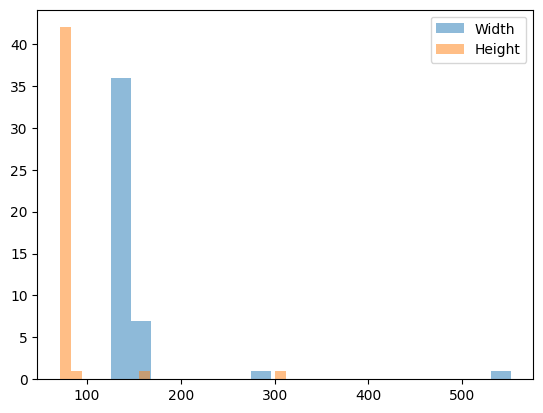

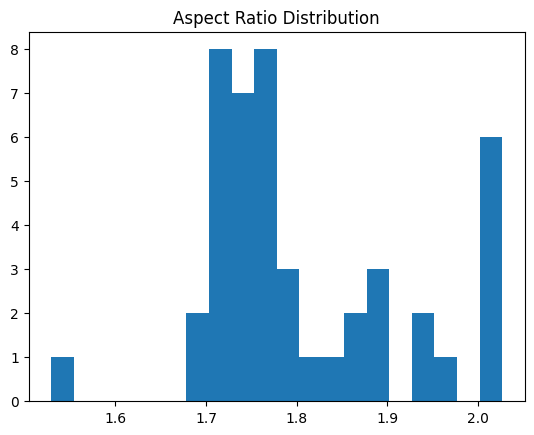

In [19]:
plt.hist(widths, bins=20, alpha=0.5, label="Width")
plt.hist(heights, bins=20, alpha=0.5, label="Height")
plt.legend()
plt.show()

plt.hist(aspect_ratios, bins=20)
plt.title("Aspect Ratio Distribution")
plt.show()